In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

data = pd.read_csv('household_power_consumption.csv')

# Convert 'Date' column to datetime type
data['Date'] = pd.to_datetime(data['Date'] + ' ' + data['Time'], dayfirst=True)

# Makes sure the columns contain numeric values
data['Global_active_power'] = pd.to_numeric(data['Global_active_power'], errors='coerce')
data['Global_reactive_power'] = pd.to_numeric(data['Global_reactive_power'], errors='coerce')
data['Voltage'] = pd.to_numeric(data['Voltage'], errors='coerce')
data['Global_intensity'] = pd.to_numeric(data['Global_intensity'], errors='coerce')
data['Sub_metering_1'] = pd.to_numeric(data['Sub_metering_1'], errors='coerce')
data['Sub_metering_2'] = pd.to_numeric(data['Sub_metering_2'], errors='coerce')
data['Sub_metering_3'] = pd.to_numeric(data['Sub_metering_3'], errors='coerce')

# Remove rows that has missing values
data.dropna(inplace=True)

# This Aggregate data as a daily average
daily_data = data.groupby(data['Date'].dt.date).agg({
    'Global_active_power': 'mean',
    'Global_reactive_power': 'mean',
    'Voltage': 'mean',
    'Global_intensity': 'mean',
    'Sub_metering_1': 'mean',
    'Sub_metering_2': 'mean',
    'Sub_metering_3': 'mean'
}).reset_index()

# Extract year, month, and day features
daily_data['Year'] = pd.to_datetime(daily_data['Date']).dt.year
daily_data['Month'] = pd.to_datetime(daily_data['Date']).dt.month
daily_data['Day'] = pd.to_datetime(daily_data['Date']).dt.day

# Drop the original 'Date' column
daily_data.drop(columns=['Date'], inplace=True)

# Split data into features (X) and target (y)
X = daily_data[['Year', 'Month', 'Day', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']]
y = daily_data['Global_active_power']

# Split the data into training and testing sets using train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# hyperparameter grid definition appropriate for Random Forest Regression
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': ['sqrt'],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Random Forest Regressor for prediction
rf = RandomForestRegressor()

# Grid Search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=0)

# Fit the grid search model
grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters found:")
print(grid_search.best_params_)

# Prediction
y_pred = grid_search.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)
mean_actual = y_test.mean()
rae = np.mean(np.abs(y_test - y_pred)) / np.mean(np.abs(y_test - mean_actual))
print("Relative Absolute Error (RAE):", rae)

Best parameters found:
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Mean Squared Error (MSE): 0.016622026111493167
Root Mean Squared Error (RMSE): 0.12892643682151914
Relative Absolute Error (RAE): 0.1358143416936729


This is the output show the hyperparameter values used for the grid search and it shows the Mean Squared Error was the smallest, compared to Root Mean Squared Error and Relative Absolute Error, but they all had very small errors. The test split test size was 50%.

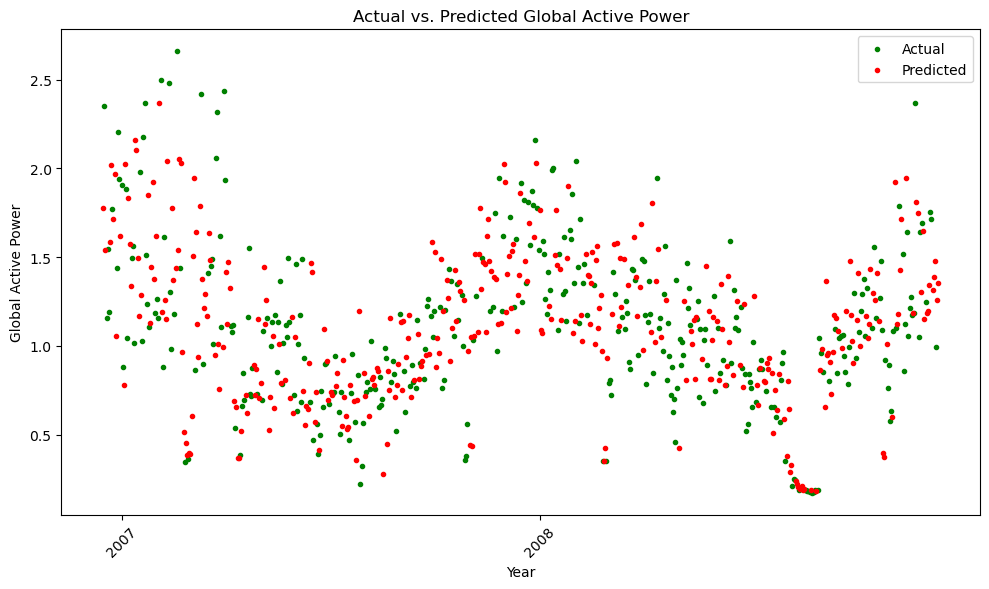

In [2]:
# Visualization that shows both the actual and predicted values. 
plt.figure(figsize=(10, 6))

plt.scatter(X_train.index, y_train, label='Actual', marker='.', color='green')

plt.scatter(X_test.index, y_pred, label='Predicted', marker='.', color='red')

# Customize x-axis labels to show only the years 2007 and 2008
tick_locations = []
tick_labels = []
for index, row in daily_data.iterrows():
    if row['Year'] == 2007 and row['Month'] == 1 and row['Day'] == 1:  
        tick_locations.append(index)
        tick_labels.append('2007')  
    elif row['Year'] == 2008 and row['Month'] == 1 and row['Day'] == 1: 
        tick_locations.append(index)
        tick_labels.append('2008')  

plt.xticks(tick_locations, tick_labels, rotation=45)

plt.title('Actual vs. Predicted Global Active Power')
plt.xlabel('Year')
plt.ylabel('Global Active Power')
plt.legend()
plt.tight_layout()
plt.show()

This graph shows the Global Active Power with the daily average throughout the two years. It shows that actual which is the green dots and the predicted is the red dot. The difference between the actual and predicted using Random Forest Regression with multiple regression using independent values are Year, Month, Day, and the daily averages for Global_reactive_power, Voltage, Global_intensity, Sub_metering_1, Sub_metering_2, and Sub_metering_3. The dependent variable is the daily average for Global_active_power.

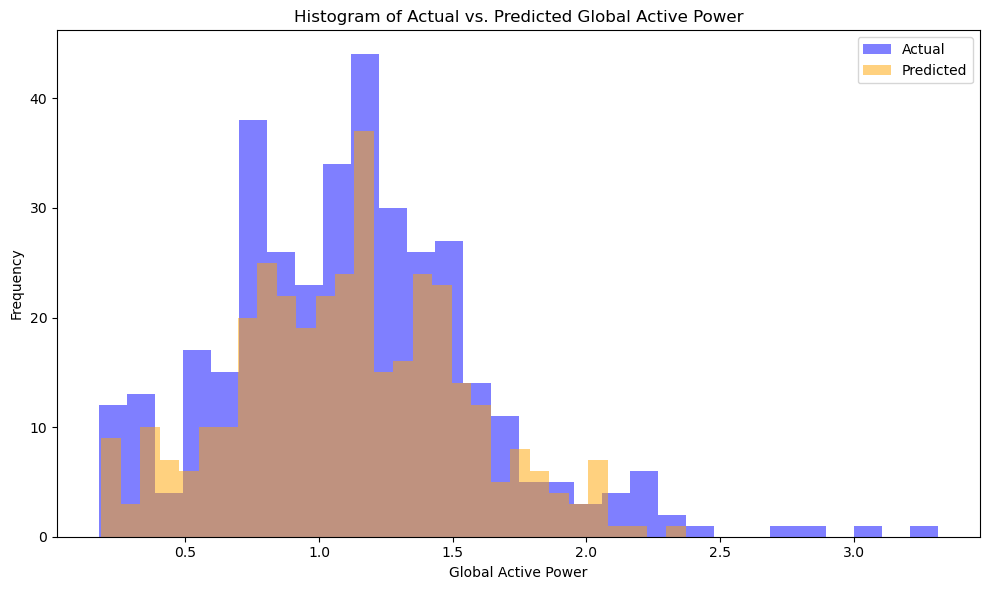

In [3]:
# Visualization: Histograms of Actual and Predicted Global Active Power
plt.figure(figsize=(10, 6))

plt.hist(y_test, bins=30, alpha=0.5, color='blue', label='Actual')

plt.hist(y_pred, bins=30, alpha=0.5, color='orange', label='Predicted')

plt.title('Histogram of Actual vs. Predicted Global Active Power')
plt.xlabel('Global Active Power')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

This is the histogram between the actual and predicted values for the daily average of the global active power and the frequency is higher between when the global active power is between 1.0 -1.5.

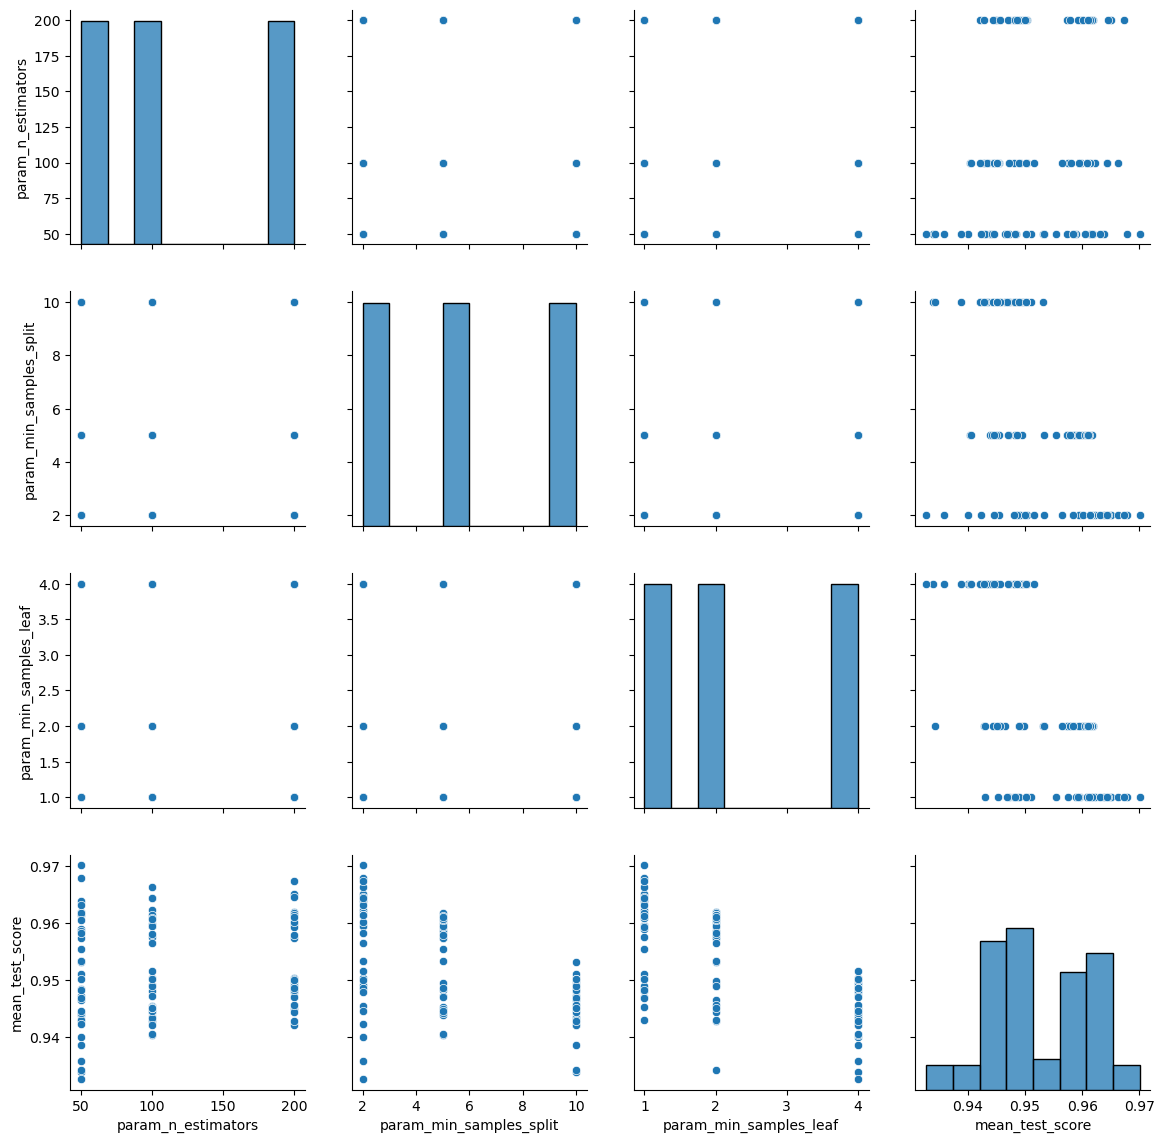

In [4]:
# Visualize pairs of hyperparameters using pairplot
warnings.filterwarnings("ignore", message="The figure layout has changed to tight", module="seaborn.axisgrid")

results = pd.DataFrame(grid_search.cv_results_)
sns.pairplot(results[['param_n_estimators', 'param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf', 'mean_test_score']])

plt.gcf().set_size_inches(12, 12)

plt.subplots_adjust(top=0.95, bottom=0.05, left=0.05, right=0.95, hspace=0.2, wspace=0.2)

# Show the plot
plt.show()


This is the pairplot to show the comparisions of pairs for the hyperplot.



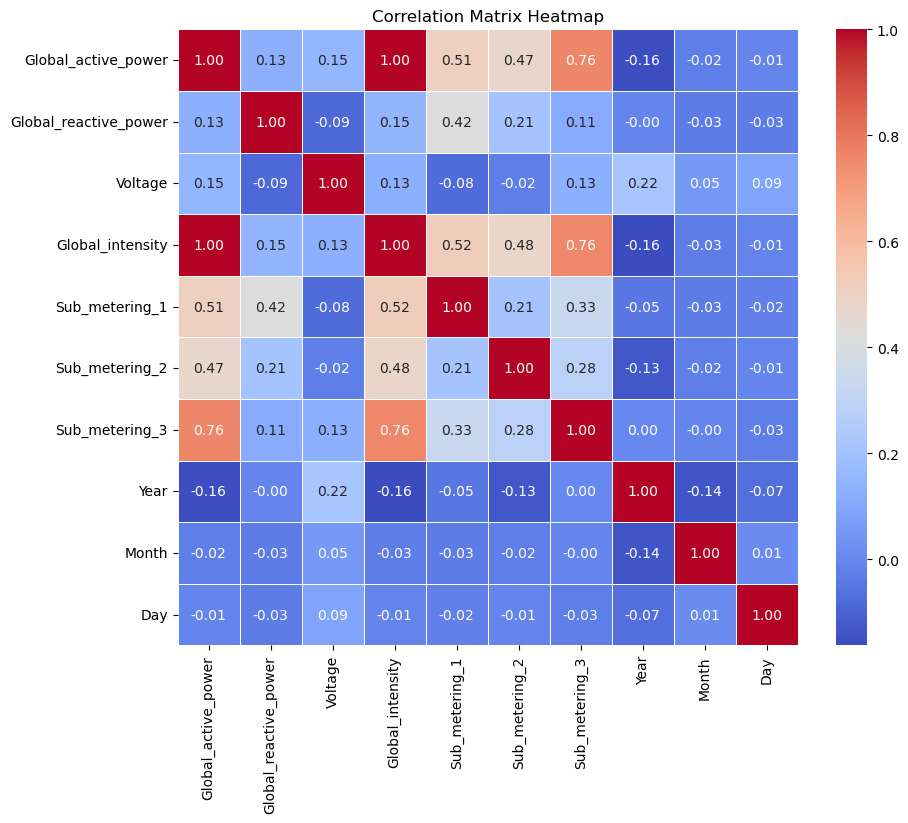

In [5]:
# Calculate the correlation matrix of all the daily average values
corr_matrix = daily_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()


This is the heatmap that shows the correlation for all the combinations of the daily averages for two variables. This is nessasary because these were used as independent variables when making a prediction using random forest variables and as for the next step in this project this will be useful to make in depth analysis for these other variables and how the make an impact for the global active power throughout the two years. And based on the heatmap there are some strong correlations of a combination of two variables that are shown over here.